In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

os.environ['TEJAPI_KEY'] = "Your API Key"
os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'

In [2]:
from zipline.data import bundles
from zipline.api import *
from zipline.finance import commission, slippage
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.pipeline import *
from zipline.TQresearch.tej_pipeline import run_pipeline
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.data import TWEquityPricing
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline

In [3]:
import TejToolAPI
from zipline.sources.TEJ_Api_Data import get_universe

# Get all stock of TWSE & OTC 
pool = get_universe(start = '2010-01-01', 
                    end = '2023-12-29',
                    mkt = ['TWSE', 'OTC'],
                    stktp_e=['Common Stock-Foreign', 'Common Stock']
                    )

# "d0001" is the column of monthly revenue
columns = ["ip12"]
data = TejToolAPI.get_history_data(
    ticker = pool,
    columns = columns,
    fin_type = 'Q',
    transfer_to_chinese = True,
    start = pd.Timestamp("2010-01-01"),
    end = pd.Timestamp("2023-12-29"),
)

Currently used TEJ API key call quota 4/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 10899362/9223372036854775807 (0.0%)
Currently used TEJ API key call quota 127/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 16982670/9223372036854775807 (0.0%)


In [4]:
data

,股票代碼,日期,營業總收入_Q
0,1101,2010-01-04,22213159.0
1,1101,2010-01-05,22213159.0
2,1101,2010-01-06,22213159.0
3,1101,2010-01-07,22213159.0
4,1101,2010-01-08,22213159.0
...,...,...,...
5448720,9962,2023-12-25,846859.0
5448721,9962,2023-12-26,846859.0
5448722,9962,2023-12-27,846859.0
5448723,9962,2023-12-28,846859.0


In [5]:
from logbook import Logger, StderrHandler, INFO
# Use logbook to log messages
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('get_universe')

# Set the interval of backtesting
start = '2010-01-01'
end = '2023-12-29'
os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(pool) + ' ' + 'IR0001'

# Ingest data to tquant
!zipline ingest -b tquant

[2024-10-02 05:26:12.965180] INFO: zipline.data.bundles.core: Ingesting tquant.
Merging daily equity files:  [####################################]      
Currently used TEJ API key call quota 133/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 27945211/9223372036854775807 (0.0%)
[2024-10-02 05:31:51.425289] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [6]:
# Rename each column.
data.rename(columns={'股票代碼':'coid', '日期':'mdate', '營業總收入_Q':'revenue'}, inplace=True)

# Sort the data based on `coid` and `mdate` to ensure the correct chronological order.
data.sort_values(by=['coid', 'mdate'], inplace=True)

# data type of each column.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5448725 entries, 0 to 5448724
Data columns (total 3 columns):
 #   Column   Dtype         
---  ------   -----         
 0   coid     object        
 1   mdate    datetime64[ns]
 2   revenue  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 166.3+ MB


In [7]:
data.sort_values(by=['mdate', 'coid']).reset_index().drop(columns='index')

,coid,mdate,revenue
0,1101,2010-01-04,22213159.0
1,1102,2010-01-04,12633158.0
2,1103,2010-01-04,977625.0
3,1104,2010-01-04,1574606.0
4,1107,2010-01-04,30497.0
...,...,...,...
5448720,9951,2023-12-29,1319434.0
5448721,9955,2023-12-29,262225.0
5448722,9958,2023-12-29,3645290.0
5448723,9960,2023-12-29,225078.0


In [8]:
from zipline.data import bundles
# Load the Zipline data bundle and specify the bundle name as 'tquant'.
bundle_name = 'tquant'
bundle = bundles.load(bundle_name)

from zipline.pipeline.data.dataset import Column, DataSet
from zipline.pipeline.domain import TW_EQUITIES

class CustomDataset(DataSet):
    # Define a floating point number field to store quarterly revenue
    revenue = Column(float)
    domain = TW_EQUITIES

# Create a mapping between each stock's symbol and its sid.
sids = bundle.asset_finder.equities_sids
assets = bundle.asset_finder.retrieve_all(sids)
symbol_mapping_sid = {i.symbol:i.sid for i in assets}

In [9]:
# Convert a DataFrame into a pipeline format
transform_data = data.set_index(['coid', 'mdate']).unstack('coid')
transform_data = transform_data.rename(columns = symbol_mapping_sid)
transform_data.index = transform_data.index.tz_localize('UTC')
transform_data

revenue                                   \
coid                             0           1         2          3      
mdate                                                                    
2010-01-04 00:00:00+00:00  22213159.0  12633158.0  977625.0  1574606.0   
2010-01-05 00:00:00+00:00  22213159.0  12633158.0  977625.0  1574606.0   
2010-01-06 00:00:00+00:00  22213159.0  12633158.0  977625.0  1574606.0   
2010-01-07 00:00:00+00:00  22213159.0  12633158.0  977625.0  1574606.0   
2010-01-08 00:00:00+00:00  22213159.0  12633158.0  977625.0  1574606.0   
...                               ...         ...       ...        ...   
2023-12-25 00:00:00+00:00  27002293.0  20893116.0  738527.0  1873035.0   
2023-12-26 00:00:00+00:00  27002293.0  20893116.0  738527.0  1873035.0   
2023-12-27 00:00:00+00:00  27002293.0  20893116.0  738527.0  1873035.0   
2023-12-28 00:00:00+00:00  27002293.0  20893116.0  738527.0  1873035.0   
2023-12-29 00:00:00+00:00  27002293.0  20893116.0  738527.0  1873035.0   

                                                                               \
coid                          4          5          6         7          8      
mdate                                                                           
2010-01-04 00:00:00+00:00  30497.0   961126.0   507867.0  426327.0  6164949.0   
2010-01-05 00:00:00+00:00  30497.0   961126.0   507867.0  426327.0  6164949.0   
2010-01-06 00:00:00+00:00  30497.0   961126.0   507867.0  426327.0  6164949.0   
2010-01-07 00:00:00+00:00  30497.0   961126.0   507867.0  426327.0  6164949.0   
2010-01-08 00:00:00+00:00  30497.0   961126.0   507867.0  426327.0  6164949.0   
...                            ...        ...        ...       ...        ...   
2023-12-25 00:00:00+00:00      NaN  1275216.0  1595174.0  498086.0  5956412.0   
2023-12-26 00:00:00+00:00      NaN  1275216.0  1595174.0  498086.0  5956412.0   
2023-12-27 00:00:00+00:00      NaN  1275216.0  1595174.0  498086.0  5956412.0   
2023-12-28 00:00:00+00:00      NaN  1275216.0  1595174.0  498086.0  5956412.0   
2023-12-29 00:00:00+00:00      NaN  1275216.0  1595174.0  498086.0  5956412.0   

                                      ...                                 \
coid                            9     ...      1977       1978      1979   
mdate                                 ...                                  
2010-01-04 00:00:00+00:00  1547273.0  ...  782865.0  3870913.0   34599.0   
2010-01-05 00:00:00+00:00  1547273.0  ...  782865.0  3870913.0   34599.0   
2010-01-06 00:00:00+00:00  1547273.0  ...  782865.0  3870913.0   34599.0   
2010-01-07 00:00:00+00:00  1547273.0  ...  782865.0  3870913.0   34599.0   
2010-01-08 00:00:00+00:00  1547273.0  ...  782865.0  3870913.0   34599.0   
...                              ...  ...       ...        ...       ...   
2023-12-25 00:00:00+00:00  1619138.0  ...  445258.0  5351117.0  207478.0   
2023-12-26 00:00:00+00:00  1619138.0  ...  445258.0  5351117.0  207478.0   
2023-12-27 00:00:00+00:00  1619138.0  ...  445258.0  5351117.0  207478.0   
2023-12-28 00:00:00+00:00  1619138.0  ...  445258.0  5351117.0  207478.0   
2023-12-29 00:00:00+00:00  1619138.0  ...  445258.0  5351117.0  207478.0   

                                                                     \
coid                           1980      1981       1982       1983   
mdate                                                                 
2010-01-04 00:00:00+00:00  103101.0  539885.0   365319.0  1479007.0   
2010-01-05 00:00:00+00:00  103101.0  539885.0   365319.0  1479007.0   
2010-01-06 00:00:00+00:00  103101.0  539885.0   365319.0  1479007.0   
2010-01-07 00:00:00+00:00  103101.0  539885.0   365319.0  1479007.0   
2010-01-08 00:00:00+00:00  103101.0  539885.0   365319.0  1479007.0   
...                             ...       ...        ...        ...   
2023-12-25 00:00:00+00:00   33717.0  816352.0  1319434.0   262225.0   
2023-12-26 00:00:00+00:00   33717.0  816352.0  1319434.0   262225.0   
2023-12-27 0

In [10]:
from zipline.pipeline import SimplePipelineEngine
from zipline.pipeline.data import TWEquityPricing
from zipline.pipeline.loaders import EquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader

custom_loader = {}
inputs = [CustomDataset.revenue]

# Place the custom dataset and the transformed data into the custom_loader.
for i in inputs:
    custom_loader[i] = DataFrameLoader(column=i, baseline=transform_data[i.name])

# Using a bundle stock daily data reader and an adjustment reader.
pricing_loader = EquityPricingLoader.without_fx(bundle.equity_daily_bar_reader,
                                                bundle.adjustment_reader)

# Define the choose_loader function to select the appropriate data loader based on the column name.
def choose_loader(column):
    if column.name in TWEquityPricing._column_names:
        return pricing_loader
    elif column.name in CustomDataset._column_names:     
        return custom_loader[column]
    else:
        raise Exception('Column not available')

# Create an instance of SimplePipelineEngine
engine = SimplePipelineEngine(get_loader = choose_loader,
                                asset_finder = bundle.asset_finder,
                                default_domain = TW_EQUITIES)

In [11]:
from zipline.pipeline.filters import StaticAssets

# Importing the StaticAssets filter to create a custom asset mask that excludes a specific benchmark asset.
assets_ex_IR0001 = [i for i in assets if i != bundle.asset_finder.lookup_symbol('IR0001', as_of_date=None)]
benchmark_asset = bundle.asset_finder.lookup_symbol('IR0001',as_of_date = None)

def make_pipeline():
    
    # Get the season revenue column from the CustomDataset.
    seanson_revenue = CustomDataset.revenue.latest

    # To filter out stocks with revenue in the top and bottom 20% while excluding the specific asset 'IR0001'.
    top_20_decile = seanson_revenue.percentile_between(80, 100, mask=StaticAssets(assets_ex_IR0001))
    bottom_20_decile = seanson_revenue.percentile_between(0, 20, mask=StaticAssets(assets_ex_IR0001))

    # Return value of pipeline column
    my_pipeline = Pipeline(
        columns = {
            'curr_price': TWEquityPricing.close.latest,
            'season_revenue': seanson_revenue,
            'longs': top_20_decile,
            'shorts': bottom_20_decile
        },
        screen = ~StaticAssets([benchmark_asset])
    )
    return my_pipeline

# Redefine the start and end dates for the backtesting period.
start_dt = pd.Timestamp(start, tz = 'UTC')
end_dt = pd.Timestamp(end, tz = 'UTC')
my_pipeline = engine.run_pipeline(make_pipeline(), start_dt, end_dt)
my_pipeline 

curr_price  season_revenue  \
2010-01-05 00:00:00+00:00 Equity(0 [1101])          34.30      22213159.0   
                          Equity(1 [1102])          34.55      12633158.0   
                          Equity(2 [1103])          18.40        977625.0   
                          Equity(3 [1104])          18.40       1574606.0   
                          Equity(4 [1107])           0.95         30497.0   
...                                                   ...             ...   
2023-12-29 00:00:00+00:00 Equity(1982 [9951])       76.30       1319434.0   
                          Equity(1983 [9955])       24.50        262225.0   
                          Equity(1984 [9958])      173.50       3645290.0   
                          Equity(1985 [9960])       27.30        225078.0   
                          Equity(1986 [9962])       18.25        846859.0   

                                               longs  shorts  
2010-01-05 00:00:00+00:00 Equity(0 [1101])      True   False  
                          Equity(1 [1102])      True   False  
                          Equity(2 [1103])     False   False  
                          Equity(3 [1104])     False   False  
                          Equity(4 [1107])     False    True  
...                                              ...     ...  
2023-12-29 00:00:00+00:00 Equity(1982 [9951])  False   False  
                          Equity(1983 [9955])  False   False  
                          Equity(1984 [9958])   True   False  
                          Equity(1985 [9960])  False   False  
                          Equity(1986 [9962])  False   False  

[5451368 rows x 4 columns]

In [12]:
from zipline.utils.calendar_utils import get_calendar

# Get the trading day for the 'TEJ' calendar between the interval of backtesting
cal = get_calendar('TEJ').all_sessions
cal = cal[(cal >= start) & (cal <= end)]
cal[-10:]

DatetimeIndex(['2023-12-18 00:00:00+00:00', '2023-12-19 00:00:00+00:00',
               '2023-12-20 00:00:00+00:00', '2023-12-21 00:00:00+00:00',
               '2023-12-22 00:00:00+00:00', '2023-12-25 00:00:00+00:00',
               '2023-12-26 00:00:00+00:00', '2023-12-27 00:00:00+00:00',
               '2023-12-28 00:00:00+00:00', '2023-12-29 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='C')

In [13]:
# Convert the dates into a DataFrame and calculate the difference between each date and the midpoint of the season.
cal = pd.DataFrame(cal).rename(columns={0: 'date'})

def get_quarter_end(x):
    month = (x.month - 1) // 3 * 3 + 3  # 將月份設置為3、6、9、12
    return pd.Timestamp(year=x.year, month=month, day=1, tz='UTC') + pd.offsets.MonthEnd(0)

cal['date'] = cal['date'].apply(get_quarter_end)

# Change the grouping to be based on year and quarter.
tradeday = cal.groupby([cal['date'].dt.year, cal['date'].dt.quarter]).apply(lambda x: x.head(1)).date.tolist()

# Convert the trading days to string format.
tradeday = [str(i.date()) for i in tradeday]

tradeday[:12]

['2010-03-31',
 '2010-06-30',
 '2010-09-30',
 '2010-12-31',
 '2011-03-31',
 '2011-06-30',
 '2011-09-30',
 '2011-12-31',
 '2012-03-31',
 '2012-06-30',
 '2012-09-30',
 '2012-12-31']

In [14]:
import matplotlib.pyplot as plt

def analyze(context, perf):
    fig = plt.figure(figsize=(16, 12))

    # First chart (Cumulative Return)
    ax = fig.add_subplot(311)
    ax.set_title('Strategy Results') 
    ax.plot(perf['algorithm_period_return'], linestyle='-', 
                label='algorithm period return', linewidth=3.0)
    ax.plot(perf['benchmark_period_return'], linestyle='-', 
                label='benchmark period return', linewidth=3.0)
    ax.legend()
    ax.grid(True)

    # Second chart (ending_cash) -> Observe whether it is overbought.
    ax = fig.add_subplot(312)
    ax.plot(perf['ending_cash'], 
                label='ending_cash', linestyle='-', linewidth=1.0)
    ax.axhline(y=1,c='r',linewidth=0.3)
    ax.legend()
    ax.grid(True)

[2024-10-02 05:32:04.363692]: INFO: earn_dividends: Equity(411 [2430]), cash_dividend amount: 3.0, pay_date: 2010-05-14, div_owed: 1863.0
[2024-10-02 05:32:05.595204]: INFO: earn_dividends: Equity(909 [3622]), cash_dividend amount: 10.0, pay_date: 2010-06-04, div_owed: 1040.0
[2024-10-02 05:32:05.747700]: INFO: earn_dividends: Equity(353 [2357]), cash_dividend amount: 2.1, pay_date: 2010-06-18, div_owed: 1339.8
[2024-10-02 05:32:06.163396]: INFO: earn_dividends: Equity(477 [2514]), cash_dividend amount: 0.5, pay_date: 2010-06-25, div_owed: 1014.0
[2024-10-02 05:32:06.665126]: INFO: earn_dividends: Equity(563 [2833]), cash_dividend amount: 0.49492311, pay_date: 2010-06-18, div_owed: 452.35972254
[2024-10-02 05:32:07.573761]: INFO: earn_dividends: Equity(47 [1319]), cash_dividend amount: 1.45, pay_date: 2010-06-29, div_owed: 868.55
[2024-10-02 05:32:07.864369]: INFO: earn_dividends: Equity(1791 [8070]), cash_dividend amount: 6.0, pay_date: 2010-07-15, div_owed: 1176.0
[2024-10-02 05:32:0

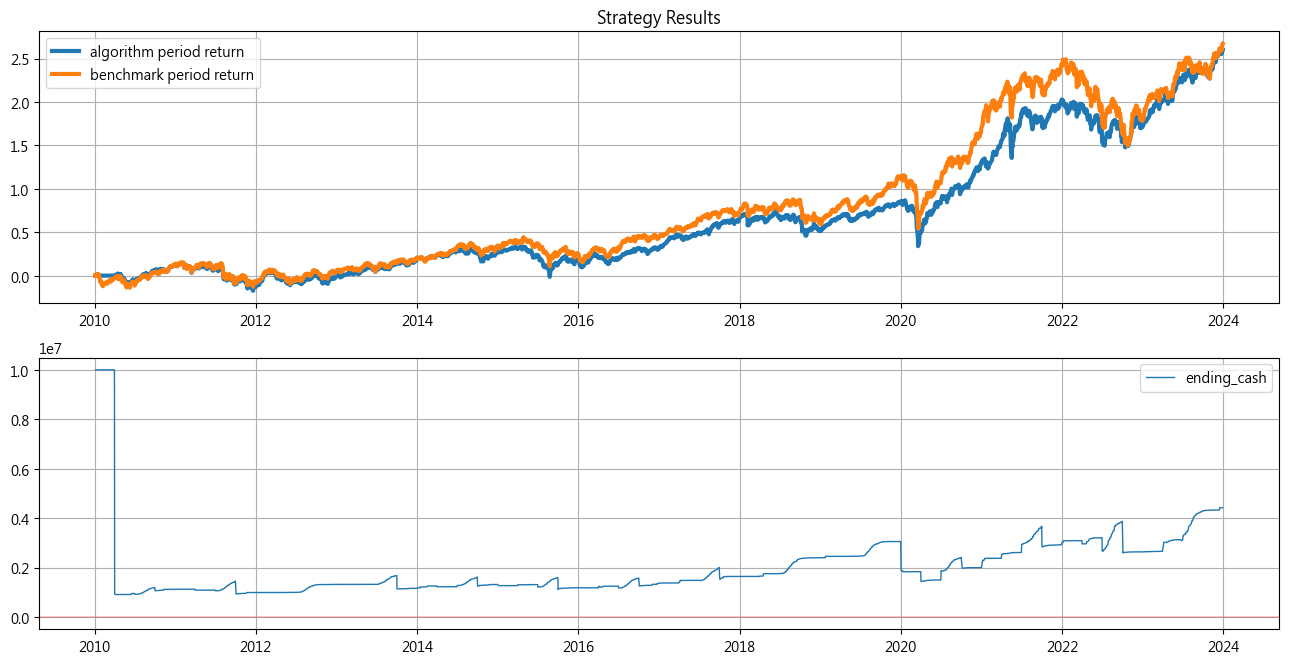

In [15]:
from zipline.algo.pipeline_algo import *

# Setting the start and end dates for the backtest
start_dt = pd.Timestamp(start, tz = 'UTC')
end_dt = pd.Timestamp(end, tz = 'UTC')

# Creating the Target Percent Pipeline Algorithm
algo = TargetPercentPipeAlgo(
                        start_session=start_dt, # Start time of the backtest
                        end_session=end_dt, # End time of the backtest
                        capital_base=1e7, # Initial capital set to 10 million        
                        tradeday=tradeday, # Trading day parameter
                        max_leverage=0.9, # Maximum leverage ratio of 0.9
                        pipeline=make_pipeline, # Use the data of pipeline 
                        slippage_model=slippage.VolumeShareSlippage(volume_limit=0.15, price_impact=0.01), # Slippage model
                        commission_model = commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003), # Commission model for the Taiwan market
                        custom_loader=custom_loader, # Custom data loader for loading specific data
                        analyze=analyze, # analyze function
                        # allow_short=True # If you want to implement a short-selling strategy, you can set this parameter to true.
)

# Run backtesting
results = algo.run()

In [16]:
results

,period_open,period_close,longs_count,long_value,treasury_return,shorts_count,long_exposure,capital_used,starting_value,net_leverage,...,excess_return,benchmark_volatility,period_label,sharpe,trading_days,algorithm_period_return,sortino,max_leverage,alpha,beta
2010-01-04 13:30:00+08:00,2010-01-04 09:01:00+08:00,2010-01-04 13:30:00+08:00,0,0.00,0.0,0,0.00,0.0,0.00,0.000000,...,0.000000,NaN,2010-01,NaN,1,0.000000,NaN,0.000000,NaN,NaN
2010-01-05 13:30:00+08:00,2010-01-05 09:01:00+08:00,2010-01-05 13:30:00+08:00,0,0.00,0.0,0,0.00,0.0,0.00,0.000000,...,-0.000433,NaN,2010-01,NaN,2,0.000000,NaN,0.000000,NaN,NaN
2010-01-06 13:30:00+08:00,2010-01-06 09:01:00+08:00,2010-01-06 13:30:00+08:00,0,0.00,0.0,0,0.00,0.0,0.00,0.000000,...,-0.014592,0.154004,2010-01,NaN,3,0.000000,NaN,0.000000,0.000000,0.000000
2010-01-07 13:30:00+08:00,2010-01-07 09:01:00+08:00,2010-01-07 13:30:00+08:00,0,0.00,0.0,0,0.00,0.0,0.00,0.000000,...,-0.003603,0.198626,2010-01,NaN,4,0.000000,NaN,0.000000,0.000000,0.000000
2010-01-08 13:30:00+08:00,2010-01-08 09:01:00+08:00,2010-01-08 13:30:00+08:00,0,0.00,0.0,0,0.00,0.0,0.00,0.000000,...,-0.008900,0.165297,2010-01,NaN,5,0.000000,NaN,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,355,31127683.36,0.0,0,31127683.36,0.0,31207993.54,0.875627,...,-0.048598,0.155884,2023-12,0.742750,3435,2.554902,0.981170,0.919125,0.019162,0.787845
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,355,31388805.50,0.0,0,31388805.50,0.0,31127683.36,0.876534,...,-0.052566,0.155876,2023-12,0.746471,3436,2.581014,0.986176,0.919125,0.019212,0.787862
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,355,31528918.55,0.0,0,31528918.55,0.0,31388805.50,0.877015,...,-0.067166,0.155866,2023-12,0.748421,3437,2.595025,0.988774,0.919125,0.019041,0.787808
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,355,31502728.69,0.0,0,31502728.69,0.0,31528918.55,0.876926,...,-0.073647,0.155844,2023-12,0.747923,3438,2.592406,0.988118,0.919125,0.018920,0.787805


Start date,2010-01-04
End date,2023-12-29
Total months,163
,Backtest
Annual return,9.843%
Cumulative returns,260.087%
Annual volatility,13.817%
Sharpe ratio,0.75
Calmar ratio,0.35
Stability,0.89
Max drawdown,-28.299%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.30,2020-01-20,2020-03-19,2020-07-02,106
1,27.68,2011-01-28,2011-12-19,2013-10-03,662
2,26.10,2015-04-27,2015-08-24,2017-01-05,420
3,18.21,2021-12-30,2022-10-13,2023-03-07,283
4,16.24,2021-04-29,2021-05-17,2021-06-28,41


Stress Events,mean,min,max
US downgrade/European Debt Crisis,-0.38%,-5.46%,3.67%
Fukushima,0.28%,-1.40%,1.60%
EZB IR Event,0.07%,-0.87%,1.34%
Flash Crash,-0.83%,-2.92%,1.55%
Apr14,-0.06%,-2.25%,0.88%
Oct14,-0.14%,-3.23%,1.78%
Fall2015,0.05%,-5.45%,2.56%
Recovery,0.00%,-5.46%,4.45%
New Normal,0.05%,-6.40%,5.27%


Top 10 long positions of all time,max
sid,
2615,1.36%
2609,1.13%
2636,1.10%
6116,1.07%
6278,1.06%
9914,1.05%
2492,1.04%
2514,1.03%
2603,1.01%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
2615,1.36%
2609,1.13%
2636,1.10%
6116,1.07%
6278,1.06%
9914,1.05%
2492,1.04%
2514,1.03%
2603,1.01%


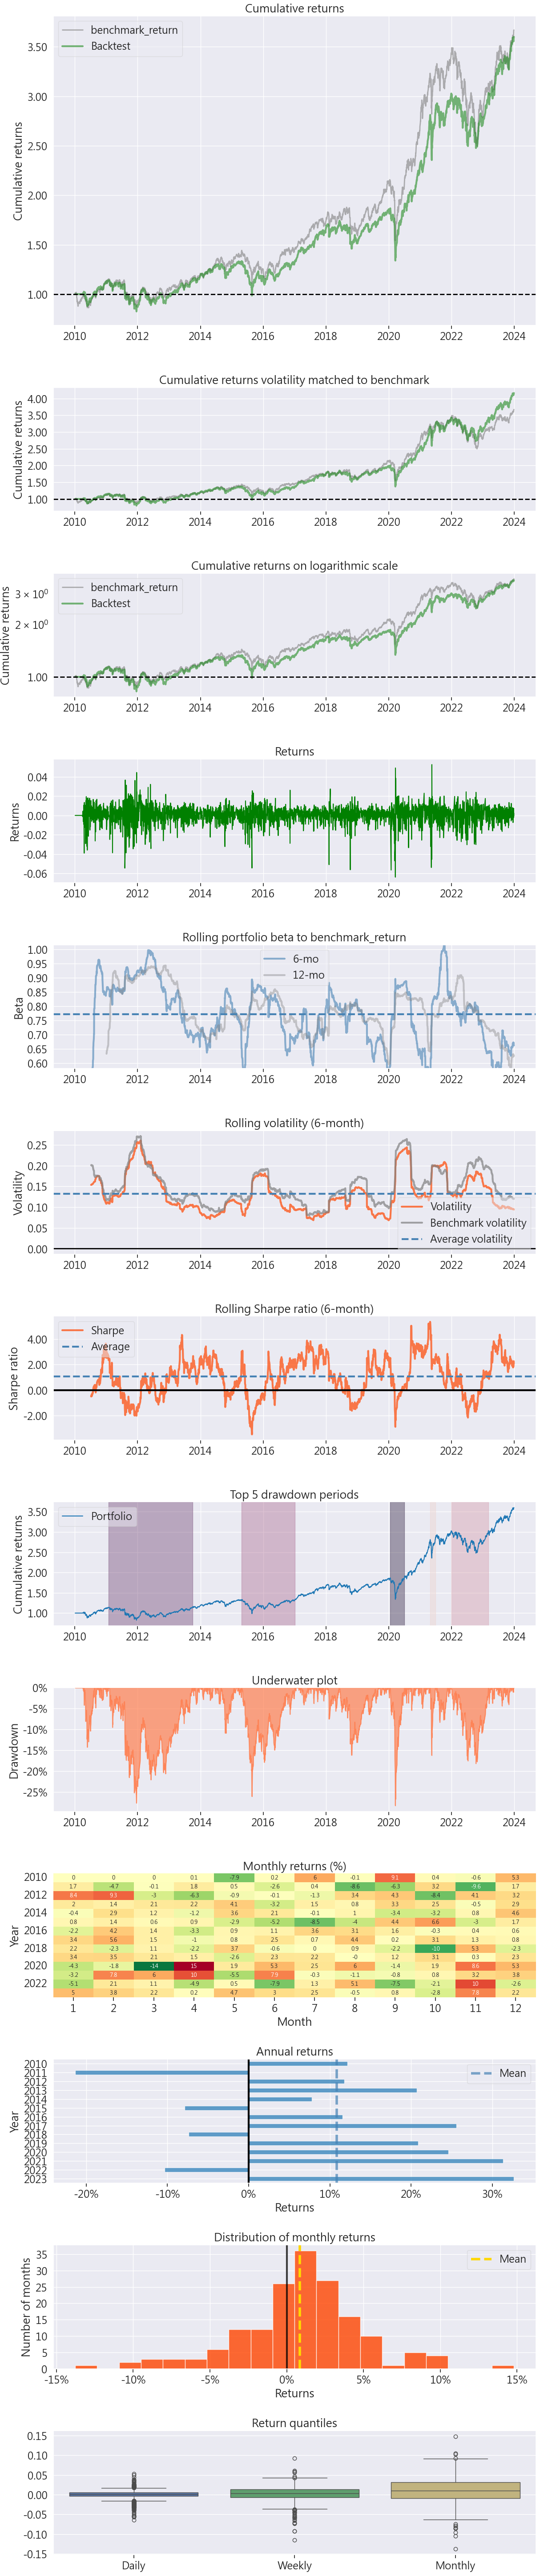

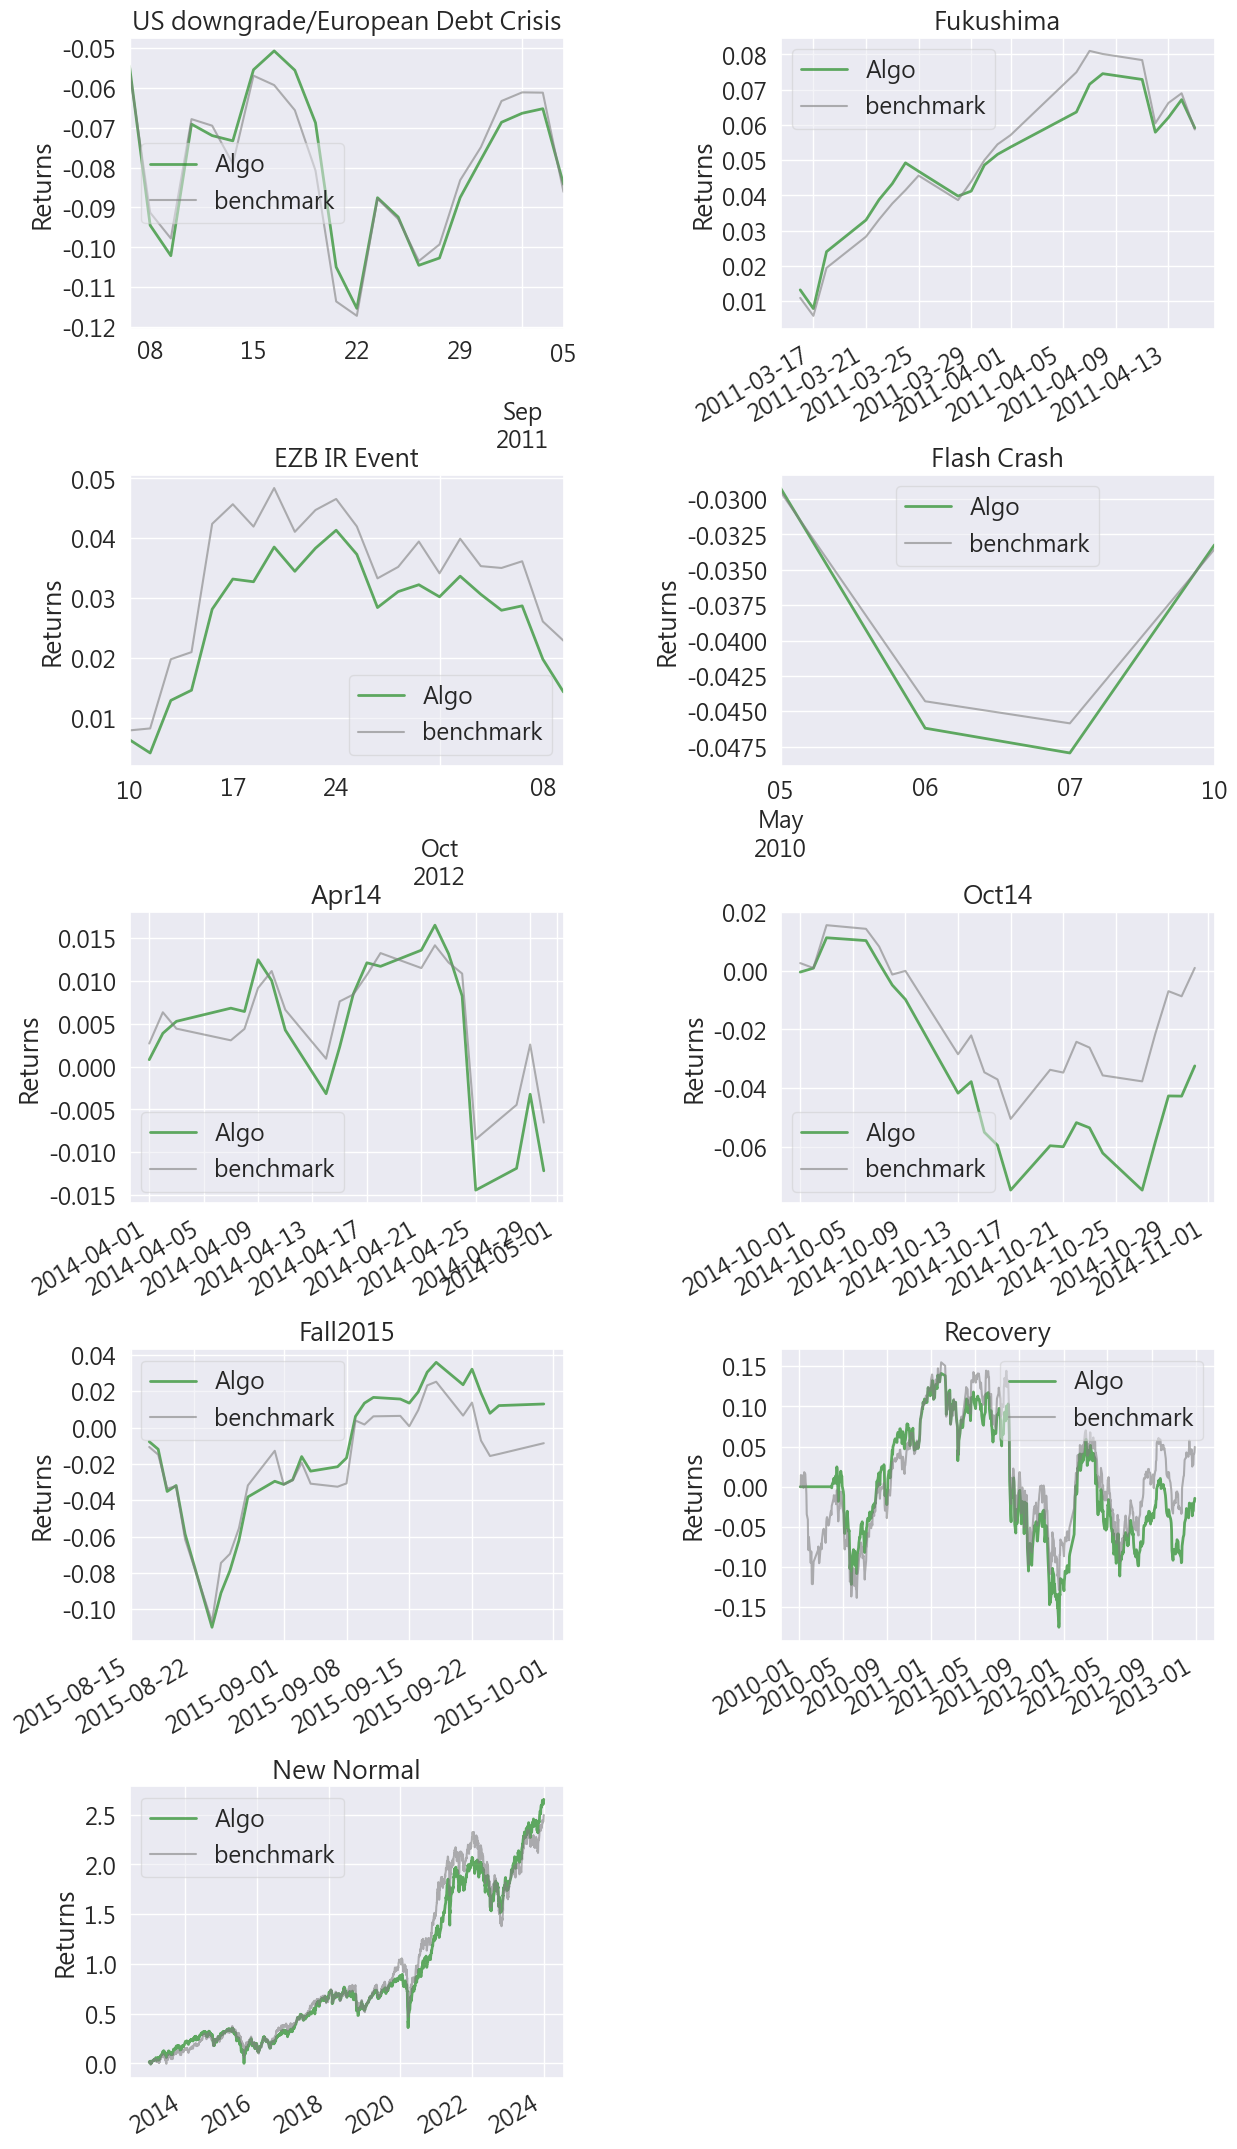

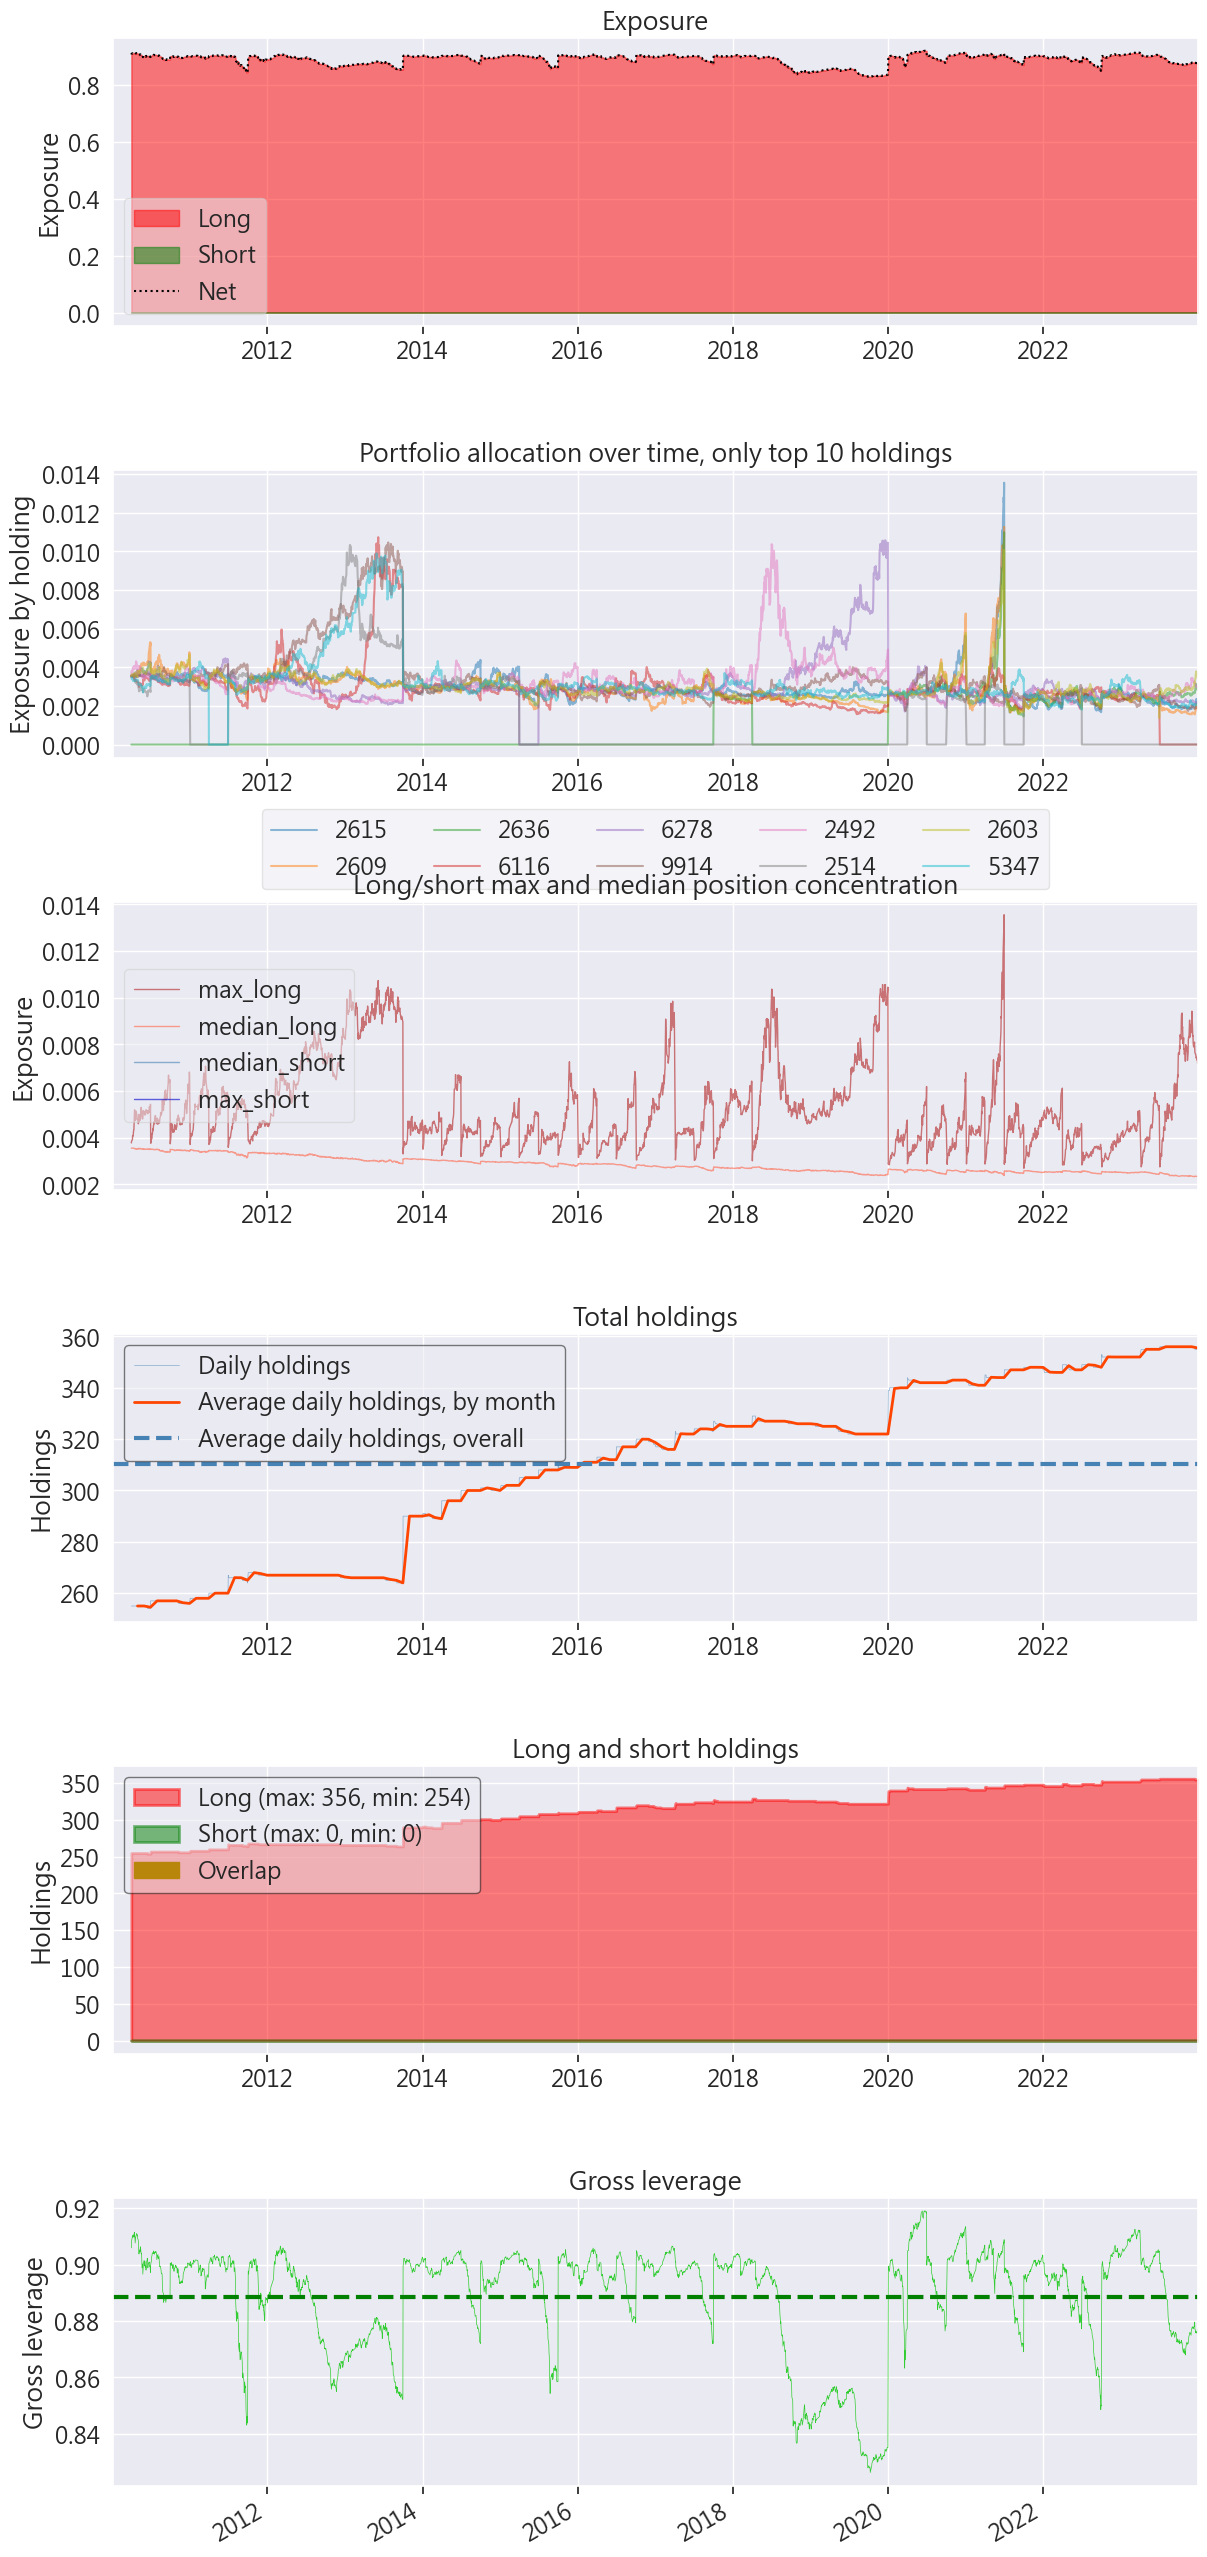

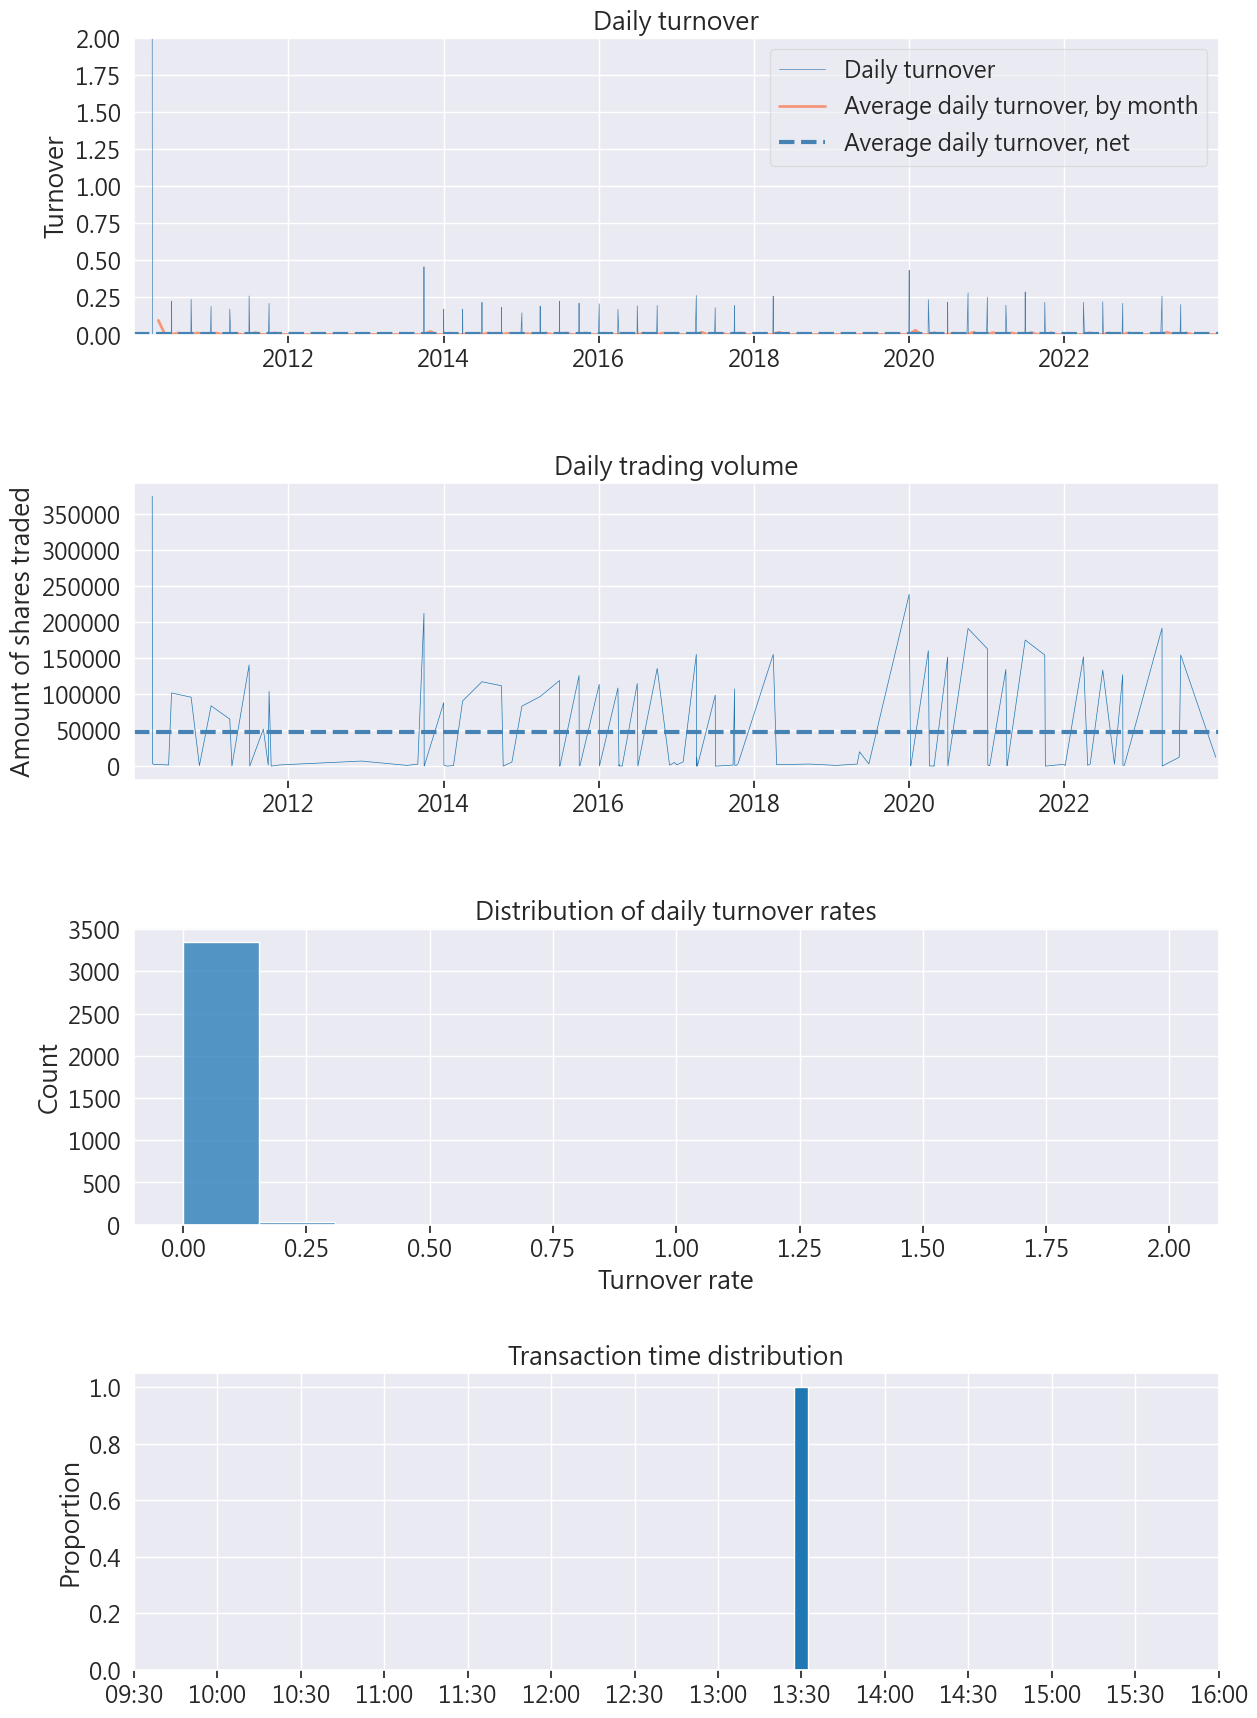

In [17]:
# Extract from the backtest results of Zipline and generate a comprehensive analysis of the portfolio.
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results['benchmark_return']

pf.tears.create_full_tear_sheet(returns=returns,
                                positions=positions,
                                transactions=transactions,
                                benchmark_rets=benchmark_rets
                                )